In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from collections import deque
import random
import gym


In [15]:
from src.optimization.dqn import build_model, DoubleDQNAgent, PortfolioEnv
from src.utils_analysis import plot_all_result
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Define the custom environment
class PortfolioEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(PortfolioEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.current_step = 0
        self.done = False
        self.portfolio_value = initial_balance

        # Actions: represent percentage allocation for each asset
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)

        # State includes asset returns and portfolio value
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(len(data.columns) + 1,), dtype=np.float32)

    def reset(self):
        self.current_balance = self.initial_balance
        self.current_step = 0
        self.portfolio_value = self.initial_balance
        self.done = False
        self.state = np.concatenate(([self.portfolio_value], self.data.iloc[self.current_step].values))
        return self.state

    def step(self, action):
        self.current_step += 1
        weights = action / action.sum()
        returns = self.data.iloc[self.current_step].values
        self.portfolio_value = self.portfolio_value * (1 + np.dot(returns, weights))
        reward = self.portfolio_value - self.current_balance  # reward is profit

        self.state = np.concatenate(([self.portfolio_value], returns))
        self.current_balance = self.portfolio_value
        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self.state, reward, self.done, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value}")
        


In [3]:


# Define the Q-network model
def build_model(input_shape, output_shape, learning_rate=0.001):
    model = Sequential([
        Dense(64, input_dim=input_shape, activation="relu"),
        Dense(64, activation="relu"),
        Dense(output_shape, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
    return model



In [4]:

# Define the Double DQN Agent
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # Initialize the policy (main) network and target network
        self.model = build_model(state_size, action_size, learning_rate)
        self.target_model = build_model(state_size, action_size, learning_rate)
        self.update_target_network()  # Ensure they start with the same weights

    def update_target_network(self):
        # Copy the weights from the policy network to the target network
        self.target_model.set_weights(self.model.get_weights())
    
    def act(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return np.random.rand(self.action_size)  # Random action
        return self.model.predict(state, verbose=0)[0]  # Action based on policy network
    
    def remember(self, state, action, reward, next_state, done):
        # Store experience in replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        # Sample a minibatch of experiences from the memory
        minibatch = random.sample(self.memory, batch_size)
        losses = []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Use the target network to calculate stable Q-value
                target += self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][np.argmax(action)] = target  # Update only the chosen action

            # Train the policy network
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            losses.append(history.history['loss'][0])

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return np.mean(losses) if losses else None  # Return average loss for tracking


In [4]:
# Load selected tickers from file
with open("data/selected_cluster_stocks.txt", "r") as f:
    tickers = [line.strip() for line in f]

# Define the file path template
test_file_path_template = "data/processed_data/test/{}_processed.csv"

# Load preprocessed data into a dictionary
test_data_dict = {}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Normed Return' and other necessary columns
    test_data_dict[ticker] = pd.read_csv(test_file_path_template.format(ticker), index_col='date', parse_dates=True)

# Define the file path template
train_file_path_template = "data/processed_data/train/{}_processed.csv"

# Load preprocessed data into a dictionary
train_data_dict = {}
data_dict={}
for ticker in tickers:
    # Load each ticker's data and assume it has 'Adj Close' or 'Normed Return' for log return calculation
    train_data_dict[ticker] = pd.read_csv(train_file_path_template.format(ticker), index_col='date', parse_dates=True)
    
data_dict = {}
for ticker in tickers:
    df = pd.read_csv(train_file_path_template.format(ticker), index_col='date', parse_dates=True)
    if 'Returns' in df.columns:
        data_dict[ticker] = df['Returns']
    else:
        print(f"Warning: 'Returns' column not found for {ticker}")
train_data = pd.DataFrame(data_dict)  # Example data loading for training



In [5]:

env = PortfolioEnv(data=train_data)
# Initialize the Double DQN agent with state and action dimensions from the environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = DoubleDQNAgent(state_size=state_size, action_size=action_size)
# Training loop with Double DQN and periodic target network updates
episodes = 10  # Define the number of episodes
update_target_frequency = 10  # Update the target network every 10 episodes
batch_size = 32

# Lists to track metrics at the end of each episode
episode_rewards = []
average_losses = []
epsilons = []


In [8]:

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    losses = []
    q_values = []  # Track Q-values once per episode
    
    for time in range(500):  # Limit each episode to 500 steps
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done or time==499:
            avg_loss = agent.replay(batch_size) if len(agent.memory) > batch_size else None
            average_losses.append(avg_loss)
            episode_rewards.append(total_reward)
            epsilons.append(agent.epsilon)
            
            # Print metrics for this episode
            print(f"Episode: {e+1}/{episodes}, Reward: {total_reward}, "
                  f"Loss: {average_losses[-1]}, "
                  f"Epsilon: {agent.epsilon:.4f}")

            # Update target network periodically
            if e % update_target_frequency == 0:
                agent.update_target_network()
            break
        


Episode: 1/10, Reward: 17794.95674093984, Loss: 523870.67145586014, Epsilon: 0.9950
Episode: 2/10, Reward: 14399.607875291262, Loss: 317072.4517095089, Epsilon: 0.9900
Episode: 3/10, Reward: 12338.948766802121, Loss: 185127.65734630823, Epsilon: 0.9851
Episode: 4/10, Reward: 15198.530234948706, Loss: 130276.9976143837, Epsilon: 0.9801
Episode: 5/10, Reward: 11826.707131097992, Loss: 57903.22890615463, Epsilon: 0.9752
Episode: 6/10, Reward: 12304.589385067615, Loss: 54667.888389110565, Epsilon: 0.9704
Episode: 7/10, Reward: 16583.73648927337, Loss: 13795.792238587514, Epsilon: 0.9655
Episode: 8/10, Reward: 18435.691157286925, Loss: 18270.64122002758, Epsilon: 0.9607
Episode: 9/10, Reward: 11082.567848792318, Loss: 8829.451130734757, Epsilon: 0.9559
Episode: 10/10, Reward: 12979.111911709988, Loss: 6702.046298652887, Epsilon: 0.9511


In [10]:


# Load preprocessed test data into a dictionary, only selecting 'Returns'
data_dict_test = {}
for ticker in tickers:
    df = pd.read_csv(test_file_path_template.format(ticker), index_col='date', parse_dates=True)
    if 'Returns' in df.columns:
        data_dict_test[ticker] = df['Returns']
    else:
        print(f"Warning: 'Returns' column not found for {ticker}")
test_data = pd.DataFrame(data_dict_test)  # Assuming data_dict_test is loaded as per your code


In [11]:

# Initialize test environment with test data
test_env = PortfolioEnv(data=test_data)

import numpy as np

# Initialize variables for tracking metrics during testing
portfolio_values = []
weights_over_time = []
state = test_env.reset()
state = np.reshape(state, [1, state_size])
initial_portfolio_value = test_env.initial_balance  # Store initial balance


In [12]:

while not test_env.done:
    # Agent takes an action based on the learned policy
    action = agent.act(state)
    weights = action / action.sum()  # Normalize to ensure sum of weights is 1
    weights_over_time.append(weights)
    
    next_state, reward, done, _ = test_env.step(weights)
    portfolio_values.append(test_env.portfolio_value)
    state = np.reshape(next_state, [1, state_size])


In [16]:
allocation_dict = {ticker: weight for ticker, weight in zip(tickers, weights_over_time[-1])}

Cumulative Portfolio Return: 16.96%
Daily Sharpe Ratio: 0.0556
Annualized Sharpe Ratio: 0.8824
Mean of Total Daily Return: 0.0697%
Standard Deviation of Total Daily Return: 1.1821%


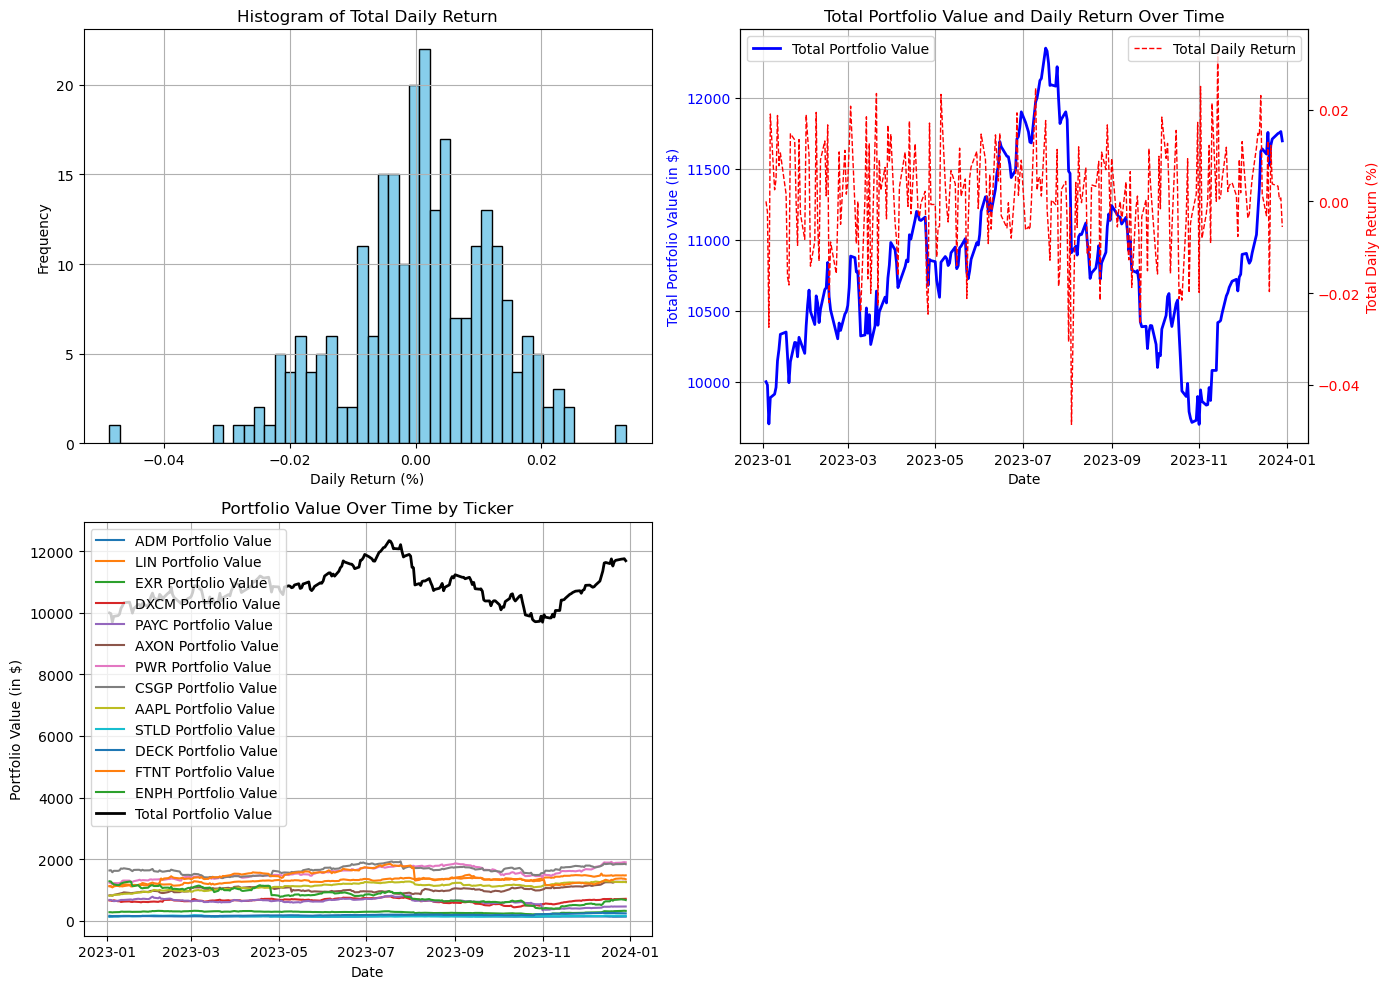

In [17]:
plot_all_result(allocation_dict,test_data_dict)